In [15]:
import numpy as np
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import os
import glob
import pyreadstat
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, matthews_corrcoef, accuracy_score, ConfusionMatrixDisplay
import random

In [2]:
os.chdir("C://Users//debor//OneDrive//University_Files//Modules//Y2S2//SP3172//data_for_interns//deb_testing//bsoid_classification")

In [5]:
def generate_labelled_frames(pose_data_raw, tremour_data_raw, save_as=None, fps=30):
    pose_data = pd.read_csv(pose_data_raw, skiprows=3)
    tremour_data = pd.read_csv(tremour_data_raw)
    labels = []
    for index, row in tremour_data.iterrows():
        start = int(row["temporal_segment_start"]) * fps
        end = int(row["temporal_segment_end"]) * fps
        label = int(row["label"])

        for i in range(start, end):
            labels.append(label)
    
    last_frame = pose_data.shape[0]
    
    remainder = last_frame - len(labels)

    for _ in range(remainder):
        labels.append(0)

    if save_as is not None:
        tremours = pd.DataFrame({"label":labels})
        tremours.to_csv(save_as)

    return labels

In [6]:
def make_bsoid_labels(mapping_path, label_path):
    """
    generate frameshifted labels (compatible with 10 fps like what BSOID does).
    in this case, divides number of labelled frames by 3.
    input: path of tremor labels in FRAMES (after running generate_labelled_frames), path of mapping data from bsoid
    output: squished (10 fps) labels
    """
    labels_raw = pd.read_csv(label_path)["label"]
    squished_labels = []
    
    for i in list(range(len(labels_raw)))[::3]:
        avg = (labels_raw[i:i+3]).mean()
        avg_round = avg.round()
        squished_labels.append(avg_round)
        labels = pd.DataFrame(squished_labels)

    mapping_data = np.genfromtxt(mapping_path, skip_header=1, delimiter=",")[:, 1]
    mapping_length = len(mapping_data)
    # print(f"mapping length = {mapping_length}")
    final_labels = labels[:mapping_length]
    # print(f"label length = {len(final_labels)}")

    return final_labels

def visualise_bsoid(mapping_path, labels=None, pose_feature=0, n_neighbors=60, n_components=3, title=None):
    """
    plots umap reduction according to bsoid params
    pose_feature refers to the type of feature extraction method (L, D or theta) as shown in bsoid paper
    0 = ENTIRE dataset including last 2 columns of mapping (cluster assignments)
    1 = L, 'pose' in delta pixels, distances between each pair of pose features
    2 = theta, 'pose vector' in delta degrees, angular change between each pair of pose features
    3 = D, 'pose vs. prev time' in delta pixels, displacement of each pose feature across timesteps
    4 = all 3 feature extraction methods
    input: path of mapping data from bsoid, FRAMESHIFT PROCESSED labels (after running make_labels)
    """
    if pose_feature != 0:
        if pose_feature == 1:
            start, stop = 1, 137
        elif pose_feature == 2:
            start, stop = 137, 273
        elif pose_feature == 3:
            start, stop = 273, -2
        elif pose_feature == 4:
            start, stop = 1, -2
        else:
            print("only pose_feature numbers 0 - 4")
            return
        mapping = pd.DataFrame(np.genfromtxt(mapping_path, skip_header=1, delimiter=",")[:, start:stop])
    else:
        mapping = pd.DataFrame(np.genfromtxt(mapping_path, skip_header=1, delimiter=",")[:, 1:])
    
    reduced, _ = umap_reduce(mapping, None, n_neighbors=n_neighbors, n_components=n_components)

    visualise_reduced(reduced, labels, title=title, three_dimensional=True)

# RandomForest Classification

In [4]:
def prep_train_test_data(pose_data, labels, train_names, test_names=None, weights=None, test_size=0.2, train_size=0.8, random_seed=None):
    training_data = []
    training_labels = []

    if weights is not None:
        training_weights = []

    testing_data = {}
    testing_labels = {}

    for name in train_names:
        pose_train = pose_data[name]
        labels_train = labels[name]

        if weights is not None:
            weights_train = weights[name]
            X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(pose_train, labels_train, weights_train, test_size=test_size,
                                                                                 train_size=train_size, random_state=random_seed)
            training_weights.append(z_train)
        else:
            X_train, X_test, y_train, y_test = train_test_split(pose_train, labels_train, test_size=test_size, train_size=0.8, random_state=random_seed)

        training_data.append(X_train)
        training_labels.append(y_train)

        if test_names is not None:
            if name in test_names:
                testing_data[name] = X_test
                testing_labels[name] = y_test
        else:
            testing_data[name] = X_test
            testing_labels[name] = y_test
        
    if(len(training_data) > 1):
        training_data = np.concatenate(training_data)
        training_labels = np.concatenate(training_labels)
        if weights is not None:
            training_weights = np.concatenate(training_weights)
    else:
        training_data = training_data[0]
        training_labels = training_labels[0]
        if weights is not None:
            training_weights = training_weights[0]

    if weights is None:
        return training_data, testing_data, training_labels, testing_labels
    else:
        return training_data, testing_data, training_labels, testing_labels, training_weights

def prep_multi_train_test_data(pose_data, labels, train_names, test_names=None, weights=None, test_size=0.2, train_size=0.8, random_seed=None):
    training_data = {}
    training_labels = {}

    if weights is not None:
        training_weights = {}

    testing_data = {}
    testing_labels = {}

    for name in train_names:
        pose_train = pose_data[name]
        labels_train = labels[name]

        if weights is not None:
            weights_train = weights[name]
            X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(pose_train, labels_train, weights_train, test_size=test_size, 
                                                                                 train_size=train_size, random_state=random_seed)
            training_weights[name] = z_train
        else:
            X_train, X_test, y_train, y_test = train_test_split(pose_train, labels_train, test_size=test_size, train_size=train_size, 
                                                                random_state=random_seed)

        training_data[name] = X_train
        training_labels[name] = y_train
        
        if test_names is not None:
            if name in test_names:
                testing_data[name] = X_test
                testing_labels[name] = y_test
        else:
            testing_data[name] = X_test
            testing_labels[name] = y_test

    if weights is None:
        return training_data, testing_data, training_labels, testing_labels
    else:
        return training_data, testing_data, training_labels, testing_labels, training_weights

def process_data(pose_data, labels, process):
    processed_data = {}
    processed_labels = {}

    for name in pose_data:
        processed_data[name] = process(pose_data[name])
        processed_labels[name] = labels[name][:processed_data[name].shape[0]]
    
    return processed_data, processed_labels

def test_classify(clf, test_data, test_labels):
    predicted_labels = clf.predict(test_data)
    mcc = matthews_corrcoef(test_labels, predicted_labels)
    f1 = f1_score(test_labels, predicted_labels)
    acc = accuracy_score(test_labels, predicted_labels)
    return {"predictions":predicted_labels, "mcc":mcc, "f1":f1, "accuracy":acc}

## (7A) CLASSIFYING MONKE VS MONKE

In [7]:
def classify_data_and_labels(name_list, folder_list):
    data = {}
    labels = {}

    for i, folder in enumerate(folder_list):
        pose_path = glob.glob(f"{folder}/*XY.csv")[0]
        mapping_path = glob.glob(f"{folder}/*mapping.csv")[0]
        glob_list = glob.glob(f"{folder}/tremor_data/*.csv")
        raw_label_path = [item for item in glob_list if item.find("frames") < 0][0]
        save_name = name_list[i]
        save_path = glob.glob(f"{folder}/tremor_data/")[0] + f"{save_name}_tremor_frames.csv"
        labelled_frames = generate_labelled_frames(pose_path, raw_label_path, save_as=save_path)
        
        data[folder] = np.genfromtxt(mapping_path, skip_header=1, delimiter=",")[:, 1:-2]

        tremor_path = glob.glob(f"{folder}/tremor_data/*frames.csv")[0]
        labels[folder] = make_bsoid_labels(mapping_path, tremor_path)
        print(f"{folder} Done!")

    return data, labels

### Koi & Boba only

In [9]:
# KOI

names_koi = ["koi_apr17", "koi_apr25", "koi_apr25_3", "koi_apr25_4", "koi_apr25_6"]
koi_folders = ["koi_1", "koi_2", "koi_3", "koi_4", "koi_5"]

koi_data, koi_labels = classify_data_and_labels(names_koi, koi_folders)

koi_1 Done!
koi_2 Done!
koi_3 Done!
koi_4 Done!
koi_5 Done!


In [10]:
# BOBA

boba_names = ["boba_apr11", "boba_apr21", "boba_apr21_2", "boba_apr25", "boba_apr25_2"]
boba_folders = ["boba_1", "boba_2", "boba_3", "boba_4", "boba_5"]

boba_data, boba_labels = classify_data_and_labels(boba_names, boba_folders)

boba_1 Done!
boba_2 Done!
boba_3 Done!
boba_4 Done!
boba_5 Done!


In [12]:
# ALL
names_all = {"koi":koi_folders, "boba":boba_folders}
data_all = {"koi":koi_data, "boba":boba_data}
labels_all = {"koi":koi_labels, "boba":boba_labels}

In [13]:
results_7a = {}

train_data_7a = {}
test_data_7a = {}
train_labels_7a = {}
test_labels_7a = {}

random_seed = 111

np.random.seed(random_seed)
random.seed(random_seed)

for name in names_all:
    pro_data, pro_labels = data_all[name], labels_all[name]
    train_data_7a[name], test_data_dict, train_labels_7a[name], test_labels_dict = prep_train_test_data(pro_data, pro_labels, names_all[name], 
                                                                                                        random_seed=random_seed)
    
    test_data_merged = []
    test_labels_merged = []

    for test_name in test_data_dict:
        test_data_merged.append(test_data_dict[test_name])
        test_labels_merged.append(test_labels_dict[test_name])

    test_data_7a[name] = np.concatenate(test_data_merged)
    test_labels_7a[name] = np.concatenate(test_labels_merged)
    print(f"{name} Done!")

koi Done!
boba Done!


In [16]:
results_7a = {}
train_names_7a = ["koi", "boba"]
test_names_7a = ["koi", "boba"]

random_seed = 1

np.random.seed(random_seed)
random.seed(random_seed)

clf = RandomForestClassifier(class_weight="balanced", random_state=random_seed)

for train_name in train_names_7a:
    results_7a[train_name] = {}
    
    clf.fit(train_data_7a[train_name], train_labels_7a[train_name].ravel())

    for test_name in test_names_7a:
        results_7a[train_name][test_name] = test_classify(clf, test_data_7a[test_name], test_labels_7a[test_name].ravel())
    print(f"{train_name} Done!")

koi Done!
boba Done!


In [18]:
visualise_mcc_7a = []

for train_name in results_7a:
    row = []
    for test_name in results_7a:
        row.append(results_7a[train_name][test_name]["mcc"])
    visualise_mcc_7a.append(row)

# visualise_acc_7a = []

# test_only_names_7a = ["horlicks", "briyani", "tutukueh"]

# for train_name in results_7a:
#     row = []
#     for test_name in test_only_names_7a:
#         row.append(results_7a[train_name][test_name]["accuracy"])
#     visualise_acc_7a.append(row)

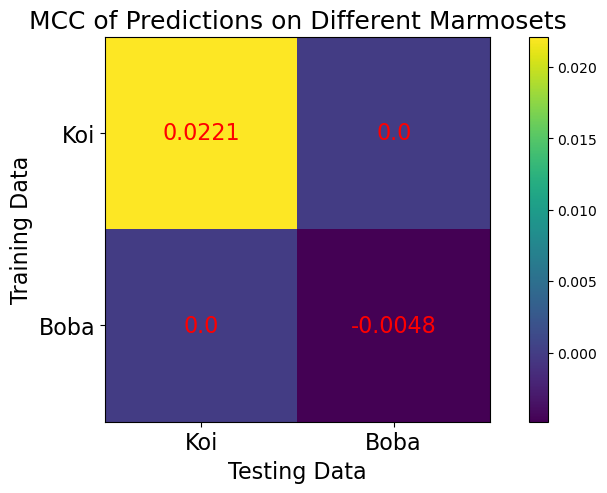

In [19]:
plt.imshow(visualise_mcc_7a, cmap='viridis', interpolation='nearest')

for i in range(len(visualise_mcc_7a)):
    for j in range(len(visualise_mcc_7a[i])):
        plt.text(j, i, round(visualise_mcc_7a[i][j], 4), ha='center', va='center', color="red", size=16)

plt.xlabel("Testing Data", size=16)
plt.ylabel("Training Data", size=16)
plt.title("MCC of Predictions on Different Marmosets", size=18)

plt.xticks(list(range(len(train_names_7a))), [s.capitalize() for s in train_names_7a], size=16)
plt.yticks(list(range(len(train_names_7a))), [s.capitalize() for s in train_names_7a], size=16)

plt.colorbar()
plt.gcf().set_size_inches(10, 5)

# Show the plot
plt.show()

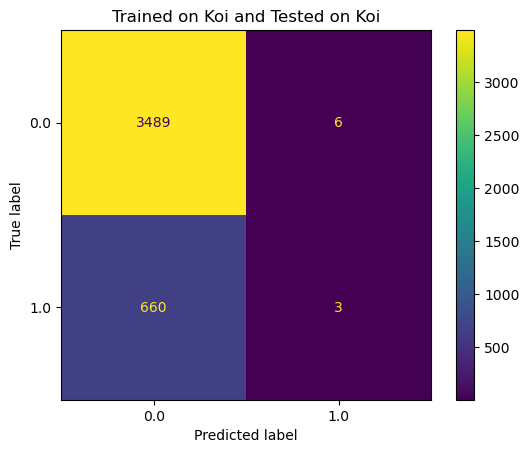

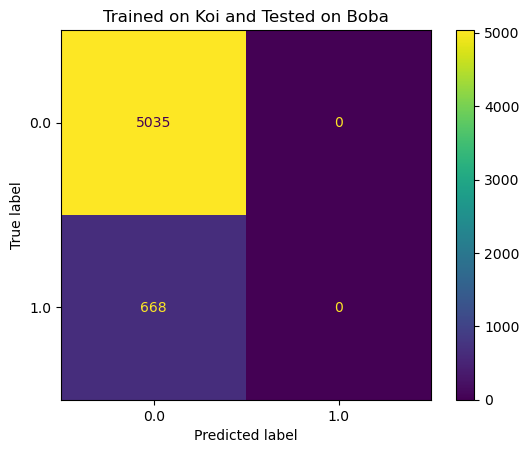

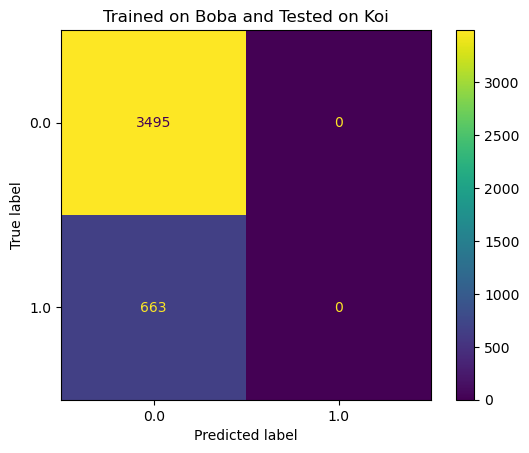

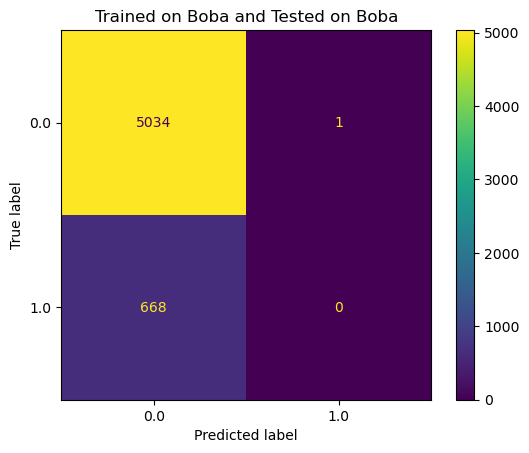

In [20]:
for train_name in results_7a:
    for test_name in results_7a[train_name]:
        cmd = ConfusionMatrixDisplay.from_predictions(test_labels_7a[test_name], 
                                                      results_7a[train_name][test_name]["predictions"], 
                                                      values_format="d")
        cmd.ax_.set_title(f"Trained on {train_name.capitalize()} and Tested on {test_name.capitalize()}")
plt.show()

## (7B) TESTING SLIDING WINDOW SIZES ONLY

In [21]:
### FUNCTION IS EXACTLY THE SAME AS make_bsoid_labels() BUT TAKES IN WHOLE DATA RATHER THAN THE DATA FILEPATH

def make_bsoid_labels_v2(data, label_path):
    """
    generate frameshifted labels (compatible with 10 fps like what BSOID does).
    in this case, divides number of labelled frames by 3.
    input: path of tremor labels in FRAMES (after running generate_labelled_frames), path of mapping data from bsoid
    output: squished (10 fps) labels
    """
    labels_raw = pd.read_csv(label_path)["label"]
    squished_labels = []
    
    for i in list(range(len(labels_raw)))[::3]:
        avg = (labels_raw[i:i+3]).mean()
        avg_round = avg.round()
        squished_labels.append(avg_round)
        labels = pd.DataFrame(squished_labels)

    mapping_length = len(data)
    # print(f"data length = {mapping_length}")
    final_labels = labels[:mapping_length]
    # print(f"label length = {len(final_labels)}")

    return final_labels

In [22]:
### FUNCTION NOW ONLY WORKS WITH 1 VIDEO AND ACCOUNTS FOR DIFFERENT SLIDING WINDOW SIZES

def classify_data_and_labels_v2(name, folder, window_size=None):
    pose_path = glob.glob(f"{folder}/*XY.csv")[0]
    mapping_path = glob.glob(f"{folder}/*mapping.csv")[0]
    glob_list = glob.glob(f"{folder}/tremor_data/*.csv")
    raw_label_path = [item for item in glob_list if item.find("frames") < 0][0]
    save_path = glob.glob(f"{folder}/tremor_data/")[0] + f"{name}_tremor_frames.csv"
    labelled_frames = generate_labelled_frames(pose_path, raw_label_path, save_as=save_path)
    
    raw_data = np.genfromtxt(mapping_path, skip_header=1, delimiter=",")[:, 1:-2]

    if window_size:
        frames = raw_data.shape[0]
        num_windows = frames - window_size + 1
        
        results = []
        for j in range(num_windows):
            window = raw_data[j:j+window_size+1]
            window_avg = np.average(window, axis=0)
            results.append(window_avg)
    else:
        results = raw_data
    
    tremor_path = glob.glob(f"{folder}/tremor_data/*frames.csv")[0]
    labels = make_bsoid_labels_v2(results, tremor_path)
    print(f"window size {window_size} for {name} in folder {folder} done!")
        
    return results, labels

### (7B_1) Testing on only 1 window size, ws=5

In [27]:
names_7b1 = "koi_apr17"
folders_7b1 = "koi_1"

data_7b1, labels_7b1 = classify_data_and_labels_v2(names_7b1, folders_7b1, window_size=5)

window size 5 for koi_apr17 in folder koi_1 done!


In [30]:
# names_all = {"koi":koi_folders, "boba":boba_folders}
# data_all = {"koi":koi_data, "boba":boba_data}
# labels_all = {"koi":koi_labels, "boba":boba_labels}

windows_7b1 = [5]
data_7b1 = {5: data_7b1}
labels_7b1 = {5: labels_7b1}

In [31]:
results_7b1 = {}

train_data_7b1 = {}
test_data_7b1 = {}
train_labels_7b1 = {}
test_labels_7b1 = {}

random_seed = 222

np.random.seed(random_seed)
random.seed(random_seed)

pro_data, pro_labels = data_7b1, labels_7b1
train_data_7b1[name], test_data_dict, train_labels_7b1[name], test_labels_dict = prep_train_test_data(pro_data, pro_labels, windows_7b1, 
                                                                                                    random_seed=random_seed)

test_data_merged = []
test_labels_merged = []

for test_name in test_data_dict:
    test_data_merged.append(test_data_dict[test_name])
    test_labels_merged.append(test_labels_dict[test_name])

test_data_7b1[name] = np.concatenate(test_data_merged)
test_labels_7b1[name] = np.concatenate(test_labels_merged)

In [33]:
results_7b1 = {}
train_names_7b1 = ["koi"]
test_names_7b1 = ["koi"]

random_seed = 222

np.random.seed(random_seed)
random.seed(random_seed)

clf = RandomForestClassifier(class_weight="balanced", random_state=random_seed)

for train_name in train_names_7b1:
    results_7b1[train_name] = {}
    
    clf.fit(train_data_7b1[train_name], train_labels_7b1[train_name])

    for test_name in test_names_7b1:
        results_7b1[train_name][test_name] = test_classify(clf, test_data_7b1[test_name], test_labels_7b1[test_name])
    print(f"{train_name} Done!")

C:\Users\debor\miniforge3\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


koi Done!


In [36]:
visualise_mcc_7b1 = []

for train_name in results_7b1:
    row = []
    for test_name in results_7b1:
        row.append(results_7b1[train_name][test_name]["mcc"])
    visualise_mcc_7b1.append(row)

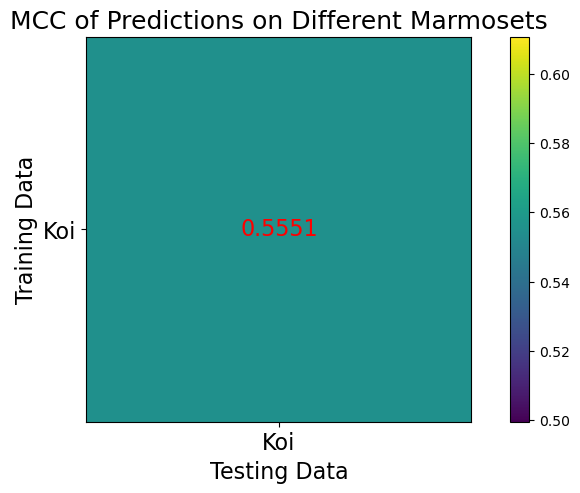

In [37]:
plt.imshow(visualise_mcc_7b1, cmap='viridis', interpolation='nearest')

for i in range(len(visualise_mcc_7b1)):
    for j in range(len(visualise_mcc_7b1[i])):
        plt.text(j, i, round(visualise_mcc_7b1[i][j], 4), ha='center', va='center', color="red", size=16)

plt.xlabel("Testing Data", size=16)
plt.ylabel("Training Data", size=16)
plt.title("MCC of Predictions on Different Marmosets", size=18)

plt.xticks(list(range(len(train_names_7b1))), [s.capitalize() for s in train_names_7b1], size=16)
plt.yticks(list(range(len(train_names_7b1))), [s.capitalize() for s in train_names_7b1], size=16)

plt.colorbar()
plt.gcf().set_size_inches(10, 5)

# Show the plot
plt.show()

### (7B_2) Testing on 4 windows sizes, ws=None, 1, 5, 10

In [38]:
names_7b2 = "koi_apr17"
folder_7b2 = "koi_1"

data_7b2 = {}
labels_7b2= {}

window_sizes = [None, 1, 5, 10]

for ws in window_sizes:
    data_7b2[ws], labels_7b2[ws] = classify_data_and_labels_v2(names_7b2, folder_7b2, window_size=ws)

window size None for koi_apr17 in folder koi_1 done!
window size 1 for koi_apr17 in folder koi_1 done!
window size 5 for koi_apr17 in folder koi_1 done!
window size 10 for koi_apr17 in folder koi_1 done!


In [40]:
results_7b2 = {}

for ws in window_sizes:
    pro_data, pro_labels = data_7b2, labels_7b2
    training_data, testing_data, training_labels, testing_labels = prep_train_test_data(pro_data, pro_labels, window_sizes)
    clf = RandomForestClassifier(class_weight="balanced")
    clf.fit(training_data, training_labels.ravel())

    testing_data_merged = np.concatenate([testing_data[name] for name in testing_data])
    testing_labels_merged = np.concatenate([testing_labels[name] for name in testing_labels])

    results_7b2[ws] = test_classify(clf, testing_data_merged, testing_labels_merged.ravel())
    print(f"{ws} done!")

None done!
1 done!
5 done!
10 done!


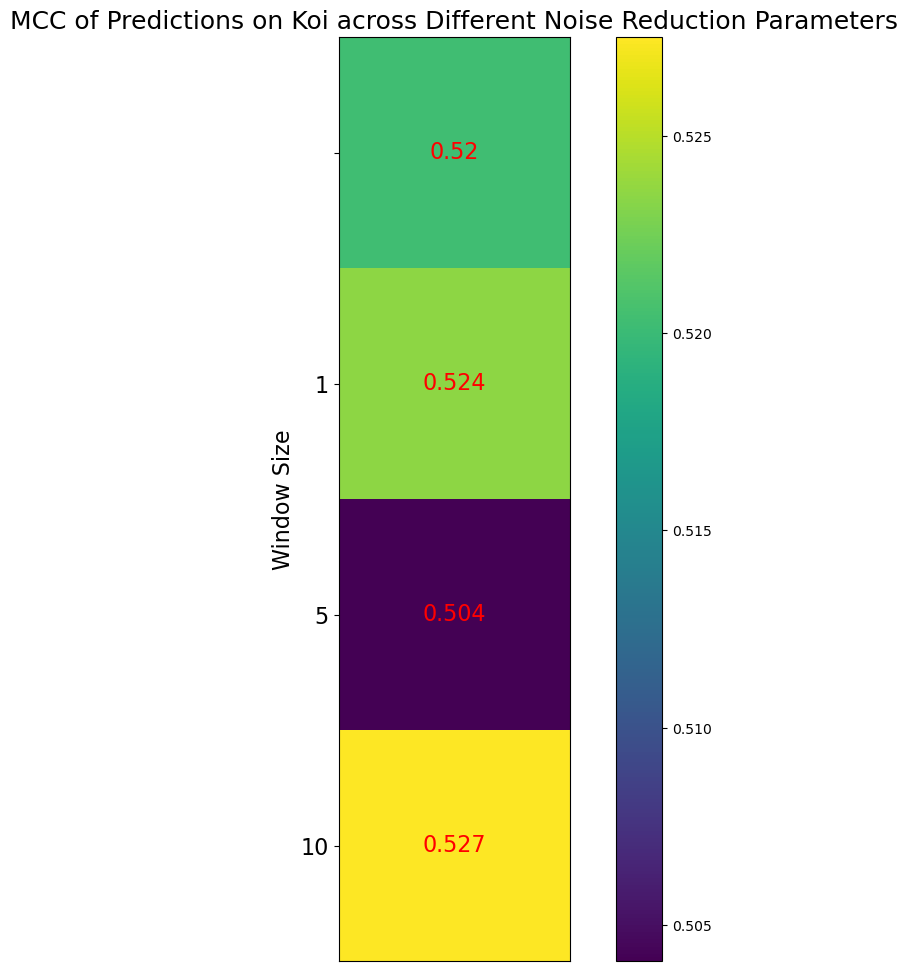

In [41]:
visualise_7b2 = []

for ws in window_sizes:
    visualise_7b2.append([results_7b2[ws]["mcc"]])

plt.imshow(visualise_7b2, cmap='viridis', interpolation='nearest')

for i in range(len(visualise_7b2)):
    for j in range(len(visualise_7b2[i])):
        plt.text(j, i, round(visualise_7b2[i][j], 3), ha='center', va='center', color="red", size=16)

# plt.xlabel("Threshold", size=16)
plt.ylabel("Window Size", size=16)
plt.title("MCC of Predictions on Koi across Different Noise Reduction Parameters", size=18)

# plt.xticks(list(range(len(thresholds))), thresholds, size=16)
plt.xticks([])
plt.yticks(list(range(len(window_sizes))), window_sizes, size=16)

plt.colorbar()
plt.gcf().set_size_inches(12, 12)

plt.show()